# Simulating a momentum distribution

## How do we simulate a momentum distribution?

Most of the code in this library assumes that we are dealing with a plane wave as only have discretely spaced momentum states. However in practice we have a wavepacket narrower than the momentum state spacing, but still finite in width. Lets think about how we can investigate the effect this has on the Bragg dynamics.

A Gaussian wavepacket is described by
$$\phi(p)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{(p-p_0)^2}{2\sigma^2}\right)$$

The Bragg diffraction Hamiltonian only couples states separated by $2\hbar k$. So to compute the effect of a Bragg pulse on some wavepacket $\phi(p)$ we need to discretize momentum space into some integer division of $\Delta p=2\hbar k/m$, where $m$ is an integer specifying the division factor. Note that if we choose momentum units of $\hbar k$ then $\Delta p=2/m$.

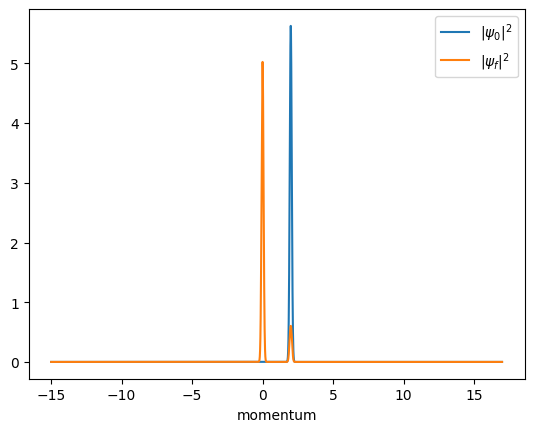

In [1]:
from mwave.integrate import gbragg, make_kvec, make_phi, make_continuous_kvec, integrate_continuous_to_discrete
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define simulation parameters
sig = 0.1
omega = 2
n0, nf = 1, 0
sigma = 0.5
tau_factor = 3

# Define grid in momentum space
dk = 0.01
npoints = int(2//dk) # Compute the number of points between momentum states separated by 2*hbar*k where hbar*k=1
k_min, k_max = -15, 16
kvec = np.arange(k_min, k_max+1, 2/npoints, dtype=np.float64)

# Calculate psi over this momentum space
psi0 = np.exp(-(kvec-2*n0)**2/(2*sig**2))/np.sqrt(sig*np.sqrt(np.pi))
psi0 = psi0.astype(np.complex128)

# Compute psif
psif = np.full(len(kvec), np.nan, dtype=np.complex128)
for i in range(npoints):
    sol = gbragg(kvec[i::npoints], np.copy(psi0[i::npoints]), 2*tau_factor*sigma, 4*(n0+nf), omega, sigma)
    psif[i::npoints] = sol.y[:,-1]

# Plot
plt.plot(kvec, np.abs(psi0)**2,label=r'$|\psi_0|^2$')
plt.plot(kvec, np.abs(psif)**2,label=r'$|\psi_f|^2$')
plt.xlabel('momentum')
plt.legend()
plt.show()

## Utilizing functions from `mwave.integrate`

There are a few functions in `mwave.integrate` that automate some of this for us, specifically `make_continuous_kvec` and `integrate_continuous_to_discrete`. We can use these to generate our continuous momentum grid and average across regions of $2\hbar k$ to convert computations in continuous space back to something like a discrete space.

(array([-2.00050251e+01, -1.80050251e+01, -1.60050251e+01, -1.40050251e+01,
       -1.20050251e+01, -1.00050251e+01, -8.00502513e+00, -6.00502513e+00,
       -4.00502513e+00, -2.00502513e+00, -5.02512563e-03,  1.99497487e+00,
        3.99497487e+00,  5.99497487e+00,  7.99497487e+00,  9.99497487e+00,
        1.19949749e+01,  1.39949749e+01,  1.59949749e+01,  1.79949749e+01,
        1.99949749e+01,  2.19949749e+01]), array([2.36799205e-34, 1.66429694e-31, 1.37708081e-28, 3.35967963e-26,
       2.86284832e-24, 5.63321789e-23, 1.02884615e-22, 8.38930652e-19,
       1.10244464e-11, 2.29813817e-05, 8.73951566e-01, 1.26014426e-01,
       1.10261292e-05, 4.89627644e-12, 3.81336342e-19, 3.28687727e-22,
       1.41543754e-22, 8.76932136e-24, 1.18586175e-25, 4.25358068e-28,
       4.51429630e-31, 7.70353196e-34]))


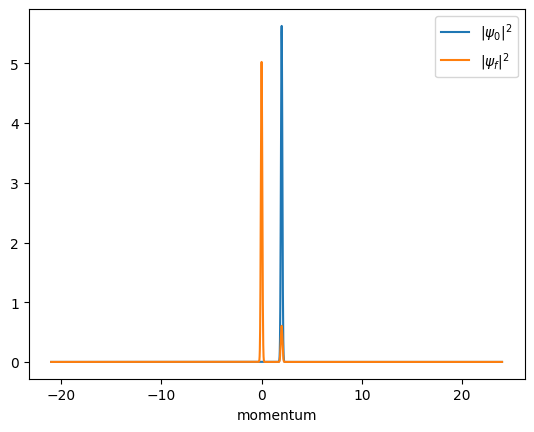

In [2]:
def make_continuous_psi(kvec, n0, sig):
    psi0 = np.exp(-(kvec-2*n0)**2/(2*sig**2))/np.sqrt(sig*np.sqrt(np.pi))
    psi0 = psi0.astype(np.complex128)
    return psi0

def gbragg_continuous(kvec, n2hk, psi0, omega, delta, sigma, tau_factor, all_times=False):    
    psif = np.full(len(kvec), np.nan, dtype=np.complex128)
    
    for i in range(n2hk):
        sol = gbragg(kvec[i::n2hk], np.copy(psi0[i::n2hk]), 2*tau_factor*sigma, delta, omega, sigma)
        psif[i::n2hk] = sol.y[:,-1]

    return psif

# Define simulation parameters
sig = 0.1 # Momentum width
dk = 0.01 # Momentum space resolution
omega = 2 # Bragg peak power
n0, nf = 1, 0 # Initial and target states
sigma = 0.5 # Bragg pulse width
tau_factor = 3 # Bragg pulse cutoff

kvec, n2hk = make_continuous_kvec(n0, nf, dk)
psi0 = make_continuous_psi(kvec, n0, sig)
psif = gbragg_continuous(kvec, n2hk, psi0, omega, 4*(n0+nf), sigma, tau_factor)

# Print the output states
print(integrate_continuous_to_discrete(kvec, psif, n2hk))

# Plot
plt.plot(kvec, np.abs(psi0)**2,label=r'$|\psi_0|^2$')
plt.plot(kvec, np.abs(psif)**2,label=r'$|\psi_f|^2$')
plt.xlabel('momentum')
plt.legend()
plt.show()

## Transform to position space

This can easily be accomplished with an FFT

In [3]:
from numpy.fft import fft, fftfreq, fftshift
xx = fftshift(fftfreq(len(kvec)))
phi0 = fftshift(fft(psi0))
phif = fftshift(fft(psif))

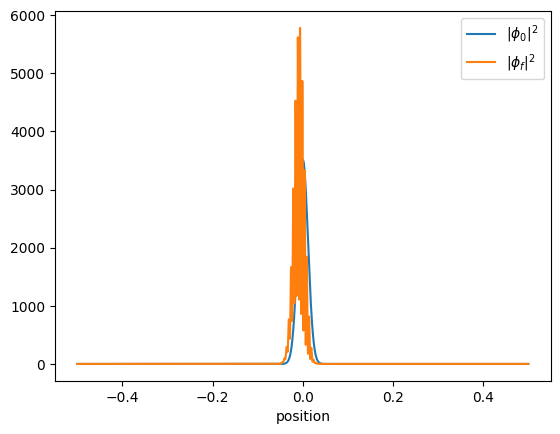

In [4]:
plt.plot(xx, np.abs(phi0)**2,label=r'$|\phi_0|^2$')
plt.plot(xx, np.abs(phif)**2,label=r'$|\phi_f|^2$')
plt.xlabel('position')
plt.legend()
plt.show()

Increasing the momentum space resolution will increase the size of position space.

## Adding time evolution

We can easily implement time evolution by adding a time-dependent phase to each momentum state. Lets make a function to do this to our computed `psif` and then another function which does an FFT of our time-dependent `psif` function.

In [5]:
fnc_psi = lambda t: psif*np.exp(-1j*t*kvec**2)
fnc_phi = lambda t: fftshift(fft(fnc_psi(t)))

Finally lets plot

<IPython.core.display.Javascript object>


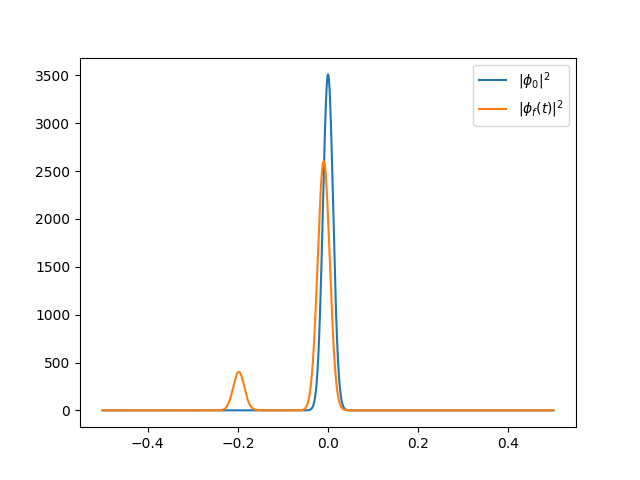

interactive(children=(FloatSlider(value=30.0, description='time', max=120.0), Output()), _dom_classes=('widget…

In [15]:
%matplotlib notebook
import ipywidgets as widgets
from IPython.display import display

fig = plt.figure()
plt.plot(xx, np.abs(phi0)**2,label=r'$|\phi_0|^2$')
l1, = plt.plot(xx, np.abs(fnc_phi(30))**2,label=r'$|\phi_f(t)|^2$')

def update(t):
    l1.set_ydata(np.abs(fnc_phi(t))**2)
    l1.set_label('$|\\phi_f(%0.0f)|^2$' % t)
    fig.canvas.draw_idle()
    
plt.legend()

t = widgets.FloatSlider(min=0,max=120,value=30,description='time')
widgets.interactive(update, t=t)

Somehow it seems that we get periodic boundary conditions. I'm not sure why this happens.